### Строим автоэнкодер

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
from os.path import join
import os
import tqdm
import tarfile
import cv2
import numpy as np


dataset_dir='./gdrive/MyDrive/LR5'

# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = join(dataset_dir,"data_test.csv")

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = join(dataset_dir,"lfw-deepfunneled.tgz")

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = join(dataset_dir,"lfw.tgz")

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_lfw_dataset(
        use_raw=False,
        dx=80,
        dy=80,
        dimx=45,
        dimy=45
        ):

    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    all_photos = []
    photo_ids = []


    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Обрабатываем лица только из сжатых данных
            if m.isfile() and m.name.endswith(".jpg"):
                # Готовим изображение
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Вырезаем лиица
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs



<ipython-input-2-eb27be8c4741>:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


  0%|          | 0/18983 [00:00<?, ?it/s]

0.5 -0.5


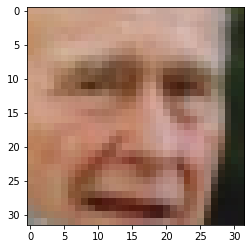

In [3]:
import pandas as pd
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

X = X.astype('float32') / 255.0 - 0.5
print(X.max(), X.min())

import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

show_image(X[6])

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [83]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPool2D,UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, ReLU, Flatten, Dense, LeakyReLU
from keras.initializers import GlorotNormal


def build_autoencoder(img_shape, code_size):
    initializer = GlorotNormal()

    encoder = Sequential(name = 'encoder')

    encoder.add(Conv2D(32, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    encoder.add(BatchNormalization())
    encoder.add(ReLU())

    encoder.add(Conv2D(64, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    encoder.add(BatchNormalization())
    encoder.add(ReLU())

    #BottleNeck
    encoder.add(Conv2D(64, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False)) #64 -> 128 = val_loss: 0.0047
    encoder.add(BatchNormalization())
    encoder.add(ReLU())

    decoder = Sequential(name = 'decoder')

    decoder.add(Conv2DTranspose(64, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    decoder.add(BatchNormalization())
    decoder.add(LeakyReLU())
    decoder.add(Dropout(0.25))


    decoder.add(Conv2DTranspose(32, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    decoder.add(BatchNormalization())
    decoder.add(LeakyReLU())
    decoder.add(Dropout(0.25))

    decoder.add(Conv2DTranspose(3, 5, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    decoder.add(BatchNormalization())
    decoder.add(LeakyReLU())
    decoder.add(Dropout(0.25))

    return encoder, decoder

In [84]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

history = autoencoder.fit(x=X_train, y=X_train, epochs=50,
                validation_data=[X_test, X_test])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Sequential)        (None, 4, 4, 64)          156640    
                                                                 
 decoder (Sequential)        (None, 32, 32, 3)         156396    
                                                                 
Total params: 313,036
Trainable params: 312,518
Non-trainable params: 518
_________________________________________________________________
None
Epoch 1/50
119/119 [==============================] - 2s 8ms/step - loss: 0.2207 - val_loss: 0.0473
Epoch 2/50
119/119 [==============================] - 1s 6ms/step - loss: 0.1391 - val_loss: 0.0430
Epoch 3/50
119/119 [==============================] - 1s 5ms/step - loss: 0.1204 - val_loss: 0.0348
Epoch 4/5

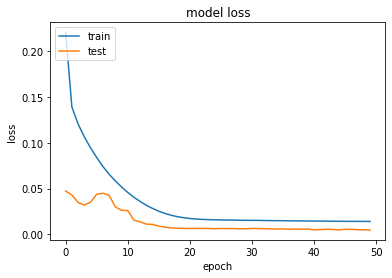

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 89ms/step


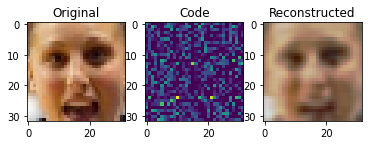

1/1 [==============================] - 0s 19ms/step


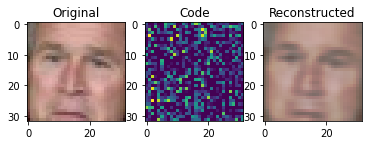

1/1 [==============================] - 0s 14ms/step


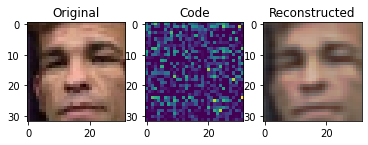

1/1 [==============================] - 0s 14ms/step


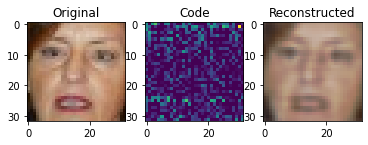

1/1 [==============================] - 0s 15ms/step


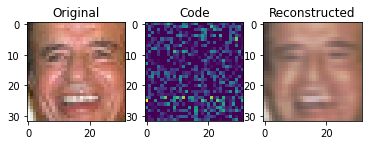

In [86]:
def visualize(img,encoder, decoder):
    """Draws original, encoded and decoded images"""
    # img[None] будет иметь шейп (1, 32, 32, 3), такой же как у модели
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder, decoder)

### Фильтрация шума

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

In [ ]:
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [ ]:
code_size = 100

encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

In [ ]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)